In [175]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

In [177]:
networkpatterns = pd.read_csv('unlabeled_network_data.csv')
networkpatterns.head(10)

,timestamp,bandwidth_in (kb),bandwidth_out (kb),jenis_probo,ping
0,2024-12-01 00:00:00,1924,509,ftp,28.23
1,2024-12-01 00:00:15,2386,1779,ftp,74.33
2,2024-12-01 00:01:10,1524,9774,http,4.15
3,2024-12-01 00:00:18,3682,3911,https,60.60
4,2024-12-01 00:02:24,3357,11831,ftp,70.43
5,2024-12-01 00:02:15,3711,7459,https,28.54
6,2024-12-01 00:05:36,206,2715,ftp,42.84
7,2024-12-01 00:02:06,2647,3627,dns,34.32
8,2024-12-01 00:00:48,6324,1684,icmp,84.90
9,2024-12-01 00:05:51,4433,811,ftp,46.48


In [178]:
networkpatterns.tail(10)

,timestamp,bandwidth_in (kb),bandwidth_out (kb),jenis_probo,ping
8105,2024-12-23 08:00:00,4410,11341,icmp,116.97
8106,2024-12-11 05:00:00,7075,3133,https,164.85
8107,2024-12-18 19:00:00,8618,5062,http,102.18
8108,2024-12-18 09:00:00,1951,4941,icmp,30.18
8109,2024-12-23 07:00:00,6899,2162,icmp,28.15
8110,2024-12-16 10:00:00,4047,11699,tcp,49.20
8111,2024-12-20 17:00:00,6874,1240,https,100.49
8112,2024-12-15 04:00:00,10656,7533,tcp,190.19
8113,2024-12-15 16:00:00,5979,3019,https,54.42
8114,2024-12-12 22:00:00,2136,1176,tcp,48.59


In [203]:
# === 3. Cek Missing Value ===
print("Informasi Dataset:")
print(networkpatterns.info())

print("\nJumlah Missing Value di Setiap Kolom:")
print(networkpatterns.isnull().sum())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8115 entries, 0 to 8114
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           8115 non-null   object 
 1   bandwidth_in (kb)   8115 non-null   float64
 2   bandwidth_out (kb)  8115 non-null   float64
 3   jenis_probo         8115 non-null   object 
 4   ping                8115 non-null   float64
 5   Label               8115 non-null   object 
dtypes: float64(3), object(3)
memory usage: 380.5+ KB
None

Jumlah Missing Value di Setiap Kolom:
timestamp             0
bandwidth_in (kb)     0
bandwidth_out (kb)    0
jenis_probo           0
ping                  0
Label                 0
dtype: int64


In [238]:
# === 4. Normalisasi Data ===
# Menentukan kolom yang akan dinormalisasi
columns_to_normalize = ['bandwidth_in (kb)', 'bandwidth_out (kb)', 'ping']
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(networkpatterns[columns_to_normalize])

# Mengganti data asli dengan data yang telah dinormalisasi
networkpatterns[columns_to_normalize] = normalized_data

print("\nData setelah normalisasi:")
print(networkpatterns.head())


Data setelah normalisasi:
             timestamp  bandwidth_in (kb)  bandwidth_out (kb) jenis_probo  \
0  2024-12-01 00:00:00           0.153368            0.034373         ftp   
1  2024-12-01 00:00:15           0.192214            0.141104         ftp   
2  2024-12-01 00:01:10           0.119734            0.813009        http   
3  2024-12-01 00:00:18           0.301186            0.320279       https   
4  2024-12-01 00:02:24           0.273859            0.985881         ftp   

       ping   Label  
0  0.136508  Normal  
1  0.368294   Flood  
2  0.015436   Flood  
3  0.299261   Flood  
4  0.348685   Flood  


In [243]:
networkpatterns['Label'] = networkpatterns.apply(
    lambda row: 'Flood' if row['bandwidth_in (kb)'] + row['bandwidth_out (kb)'] + row['ping'] > 0.9 else 'Normal',
    axis=1
)

In [244]:
# Mengecek hasil
print(networkpatterns[['bandwidth_in (kb)', 'bandwidth_out (kb)', 'ping', 'Label']].head())

   bandwidth_in (kb)  bandwidth_out (kb)      ping   Label
0           0.153368            0.034373  0.136508  Normal
1           0.192214            0.141104  0.368294  Normal
2           0.119734            0.813009  0.015436   Flood
3           0.301186            0.320279  0.299261   Flood
4           0.273859            0.985881  0.348685   Flood


In [245]:
# Memisahkan fitur (X) dan label (y)
X = networkpatterns[['bandwidth_in (kb)', 'bandwidth_out (kb)', 'ping']]
y = networkpatterns['Label']

In [246]:
print(networkpatterns['Label'].value_counts())

Label
Flood     6802
Normal    1313
Name: count, dtype: int64


In [247]:
# === 5. Undersampling ===
# Mengecek distribusi kelas
print("\nDistribusi Kelas Sebelum Undersampling:")
print(networkpatterns['Label'].value_counts())

# Memisahkan fitur (X) dan Label (y)
X = networkpatterns[['bandwidth_in (kb)', 'bandwidth_out (kb)', 'ping']]
y = networkpatterns['Label']

# Menggunakan RandomUnderSampler untuk menyeimbangkan kelas
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Menyimpan data hasil undersampling ke dalam DataFrame
resampled_data = pd.DataFrame(X_resampled, columns=['bandwidth_in (kb)', 'bandwidth_out (kb)', 'ping'])
resampled_data['Label'] = y_resampled

print("\nDistribusi Kelas Setelah Undersampling:")
print(resampled_data['Label'].value_counts())


Distribusi Kelas Sebelum Undersampling:
Label
Flood     6802
Normal    1313
Name: count, dtype: int64

Distribusi Kelas Setelah Undersampling:
Label
Flood     1313
Normal    1313
Name: count, dtype: int64


c:\Users\naufa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\naufa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


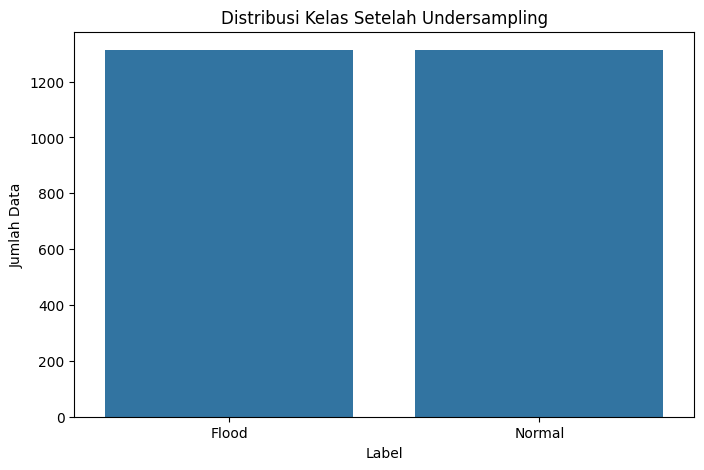


Data yang Siap untuk Training:
      bandwidth_in (kb)  bandwidth_out (kb)      ping  Label
3327           0.592113            0.531725  0.620092  Flood
4947           0.954847            0.106648  0.998140  Flood
3117           0.843774            0.536011  0.466137  Flood
3276           0.605903            0.730734  0.548746  Flood
3384           0.553267            0.632238  0.746594  Flood


In [249]:
# === 6. Visualisasi Distribusi Data ===
plt.figure(figsize=(8, 5))
sns.countplot(x='Label', data=resampled_data)
plt.title('Distribusi Kelas Setelah Undersampling')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.show()

# === 7. Dataset Siap untuk Training ===
# Menampilkan beberapa baris data
print("\nData yang Siap untuk Training:")
print(resampled_data.head())

In [252]:
# === 8. Splitting Dataset ===
# Memisahkan fitur dan label
X = resampled_data[['bandwidth_in (kb)', 'bandwidth_out (kb)', 'ping']]
y = resampled_data['Label']

# Split data ke dalam training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\nJumlah data pada training set dan testing set:")
print(f"Training set: {len(X_train)}, Testing set: {len(X_test)}")


Jumlah data pada training set dan testing set:
Training set: 1838, Testing set: 788


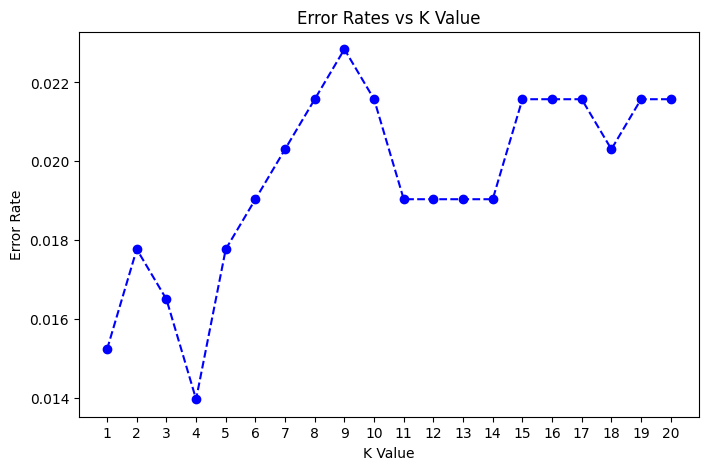

Nilai K optimal: 4


In [253]:
# === 9. Mencari Nilai K Optimal (untuk KNN) ===
error_rates = []

# Mencoba nilai K dari 1 hingga 20
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    error_rates.append(1 - accuracy_score(y_test, y_pred_k))

# Plot error rates untuk visualisasi
plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), error_rates, marker='o', linestyle='--', color='b')
plt.title('Error Rates vs K Value')
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.xticks(range(1, 21))
plt.show()

# Pilih nilai K optimal (dari grafik atau manual)
optimal_k = error_rates.index(min(error_rates)) + 1
print(f"Nilai K optimal: {optimal_k}")

In [254]:
# === 10. Training Model KNN ===
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train, y_train)

# Prediksi data testing
y_pred = knn_model.predict(X_test)

# Evaluasi dengan confusion matrix dan classification report
print("\nConfusion Matrix (KNN):")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report (KNN):")
print(classification_report(y_test, y_pred))


Confusion Matrix (KNN):
[[384  10]
 [  1 393]]

Classification Report (KNN):
              precision    recall  f1-score   support

       Flood       1.00      0.97      0.99       394
      Normal       0.98      1.00      0.99       394

    accuracy                           0.99       788
   macro avg       0.99      0.99      0.99       788
weighted avg       0.99      0.99      0.99       788




Distribusi Cluster Hasil K-Means:
cluster
1    1654
0     972
Name: count, dtype: int64


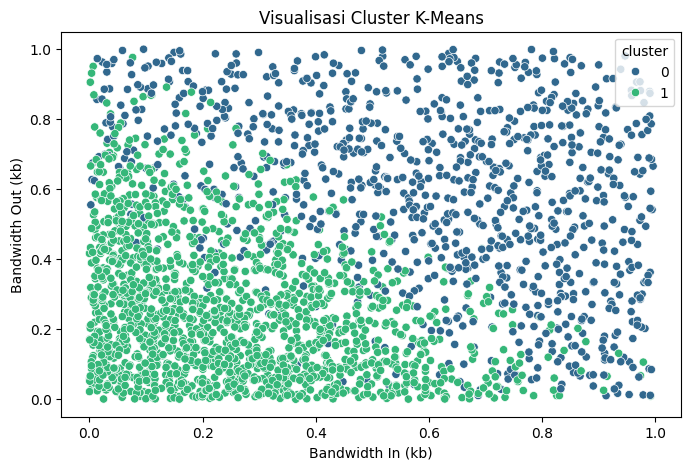

In [255]:
# === 11. Penerapan Algoritma K-Means ===
# Menentukan jumlah cluster (2 untuk Flood dan Normal)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Menambahkan label hasil clustering ke dalam data
resampled_data['cluster'] = kmeans.labels_

print("\nDistribusi Cluster Hasil K-Means:")
print(resampled_data['cluster'].value_counts())

# Visualisasi cluster
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=resampled_data['bandwidth_in (kb)'],
    y=resampled_data['bandwidth_out (kb)'],
    hue=resampled_data['cluster'],
    palette='viridis'
)
plt.title('Visualisasi Cluster K-Means')
plt.xlabel('Bandwidth In (kb)')
plt.ylabel('Bandwidth Out (kb)')
plt.show()

In [256]:
# === 12. Evaluasi Hasil K-Means ===
# Map hasil clustering ke label sebenarnya
# Misalnya, cluster 0 dianggap sebagai 'Normal', dan cluster 1 sebagai 'Flood'
resampled_data['cluster_label'] = resampled_data['cluster'].apply(lambda x: 'Normal' if x == 0 else 'Flood')

print("\nConfusion Matrix (K-Means):")
print(confusion_matrix(y, resampled_data['cluster_label']))

print("\nClassification Report (K-Means):")
print(classification_report(y, resampled_data['cluster_label']))


Confusion Matrix (K-Means):
[[ 341  972]
 [1313    0]]

Classification Report (K-Means):
              precision    recall  f1-score   support

       Flood       0.21      0.26      0.23      1313
      Normal       0.00      0.00      0.00      1313

    accuracy                           0.13      2626
   macro avg       0.10      0.13      0.11      2626
weighted avg       0.10      0.13      0.11      2626

